all positive 34 [('ICUTime', 11, '22.6806 ± 1.0766'), ('Bias term', 0, '-12.9801 ± 1.962'), ('OperationTime_h', 24, '10.8671 ± 1.3482'), ('NTproBNP', 13, '4.9281 ± 0.9008'), ('RBCT', 23, '4.7231 ± 0.9378'), ('SBP', 10, '4.5205 ± 0.6687'), ('PT_sec_minus', 30, '4.3827 ± 0.6122'), ('PLT_minus', 28, '-4.2942 ± 0.8235'), ('Fib_gL', 18, '-4.0757 ± 1.9345'), ('CREA', 22, '-3.931 ± 0.8227'), ('ALB_minus', 32, '-3.6984 ± 0.7582'), ('WBC', 16, '-3.1629 ± 0.8731'), ('T', 8, '2.9162 ± 1.7302'), ('PCT', 12, '-2.6711 ± 0.7153'), ('HOD', 25, '2.3872 ± 0.6307'), ('NEUT', 17, '1.9601 ± 0.6595'), ('TBIL', 21, '1.8366 ± 0.6071'), ('PLT', 14, '1.635 ± 1.0306'), ('HR', 9, '-1.4675 ± 0.5784'), ('UA_minus', 26, '-1.3376 ± 0.8645'), ('ALB', 19, '-1.1188 ± 0.7268'), ('NEUT_minus', 29, '1.0572 ± 0.4342'), ('HepatitisC', 3, '0.822 ± 0.4466'), ('HBP', 6, '0.7144 ± 0.3138'), ('ALT', 20, '0.7082 ± 0.7656'), ('sex', 1, '-0.6265 ± 0.2622'), ('Diabetes', 5, '0.5804 ± 0.2305'), ('TP_minus', 31, '0.5008 ± 0.5283'), ('T

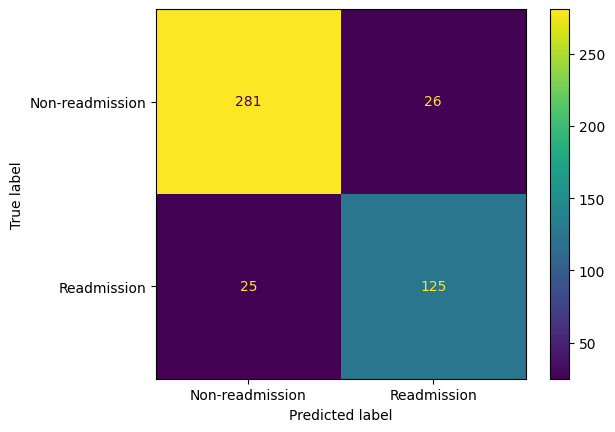

Weight,Feature
0.2293 ± 0.0262,ICUTime
0.0460 ± 0.0182,OperationTime_h
0.0368 ± 0.0131,RBCT
0.0368 ± 0.0089,SBP
0.0368 ± 0.0165,PLT_minus
0.0350 ± 0.0152,PT_sec_minus
0.0311 ± 0.0075,WBC
0.0293 ± 0.0116,CREA
0.0271 ± 0.0065,HR
0.0236 ± 0.0165,HOD


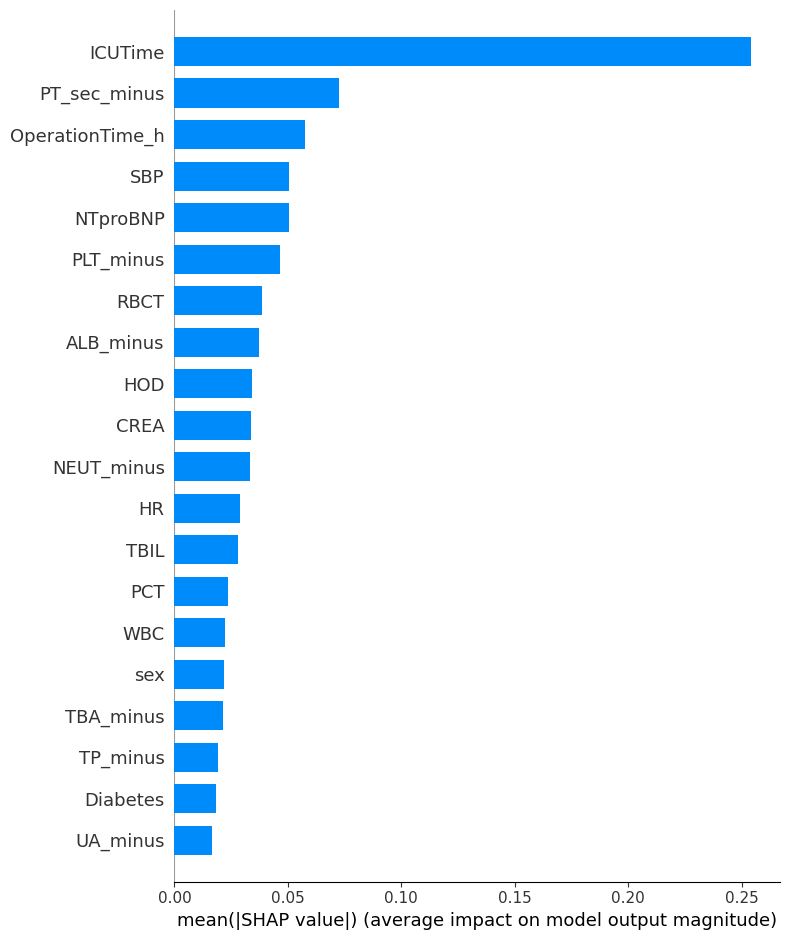

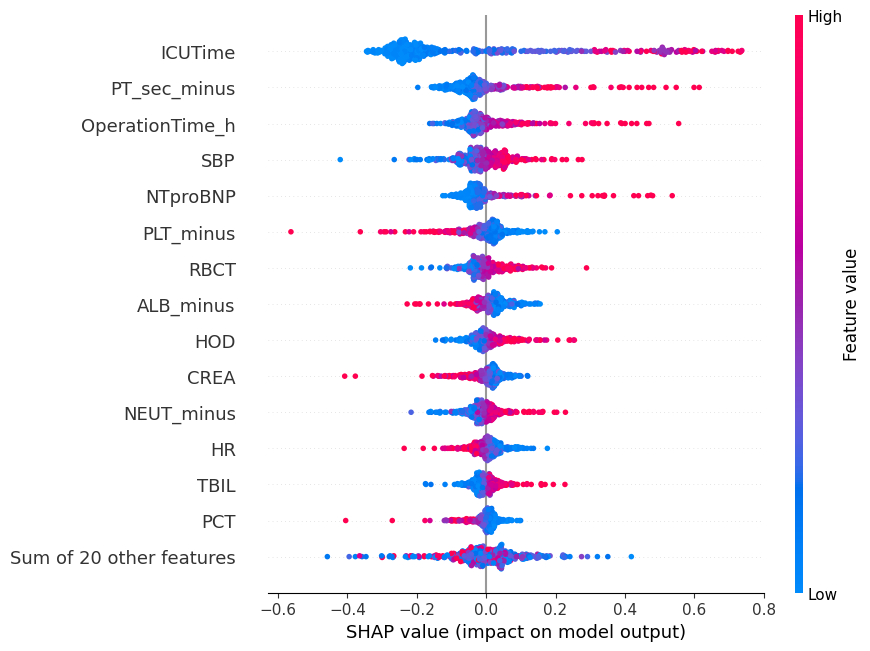

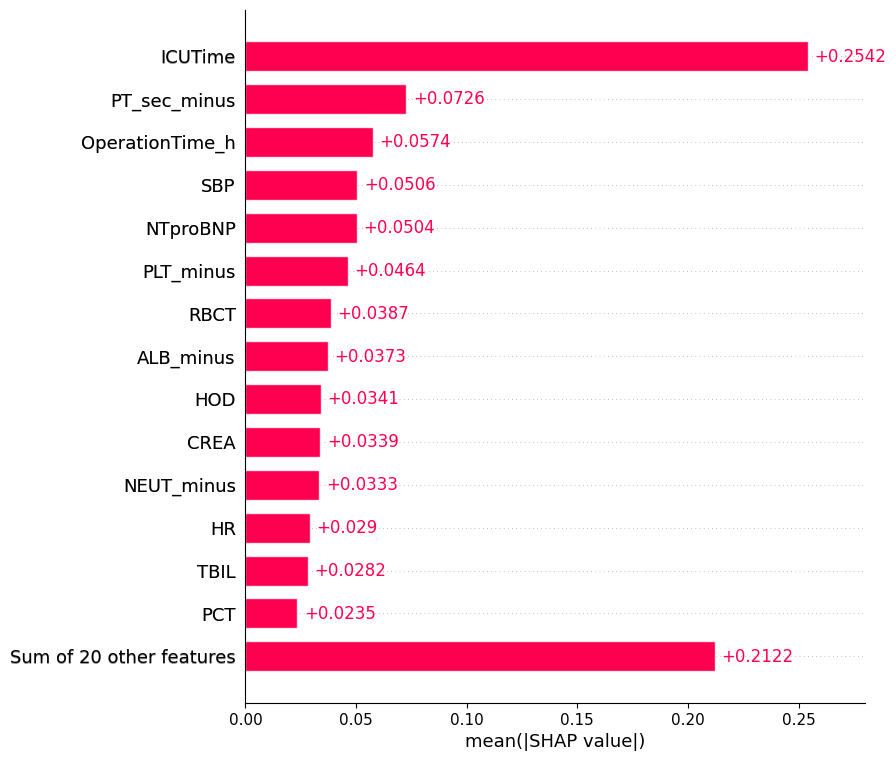

In [5]:
# %load single_test.py
import os.path

import matplotlib.pyplot as plt
import shap
import eli5
from IPython.core.display import display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler
from eli5.sklearn import PermutationImportance

from prml.linear import VariationalLogisticRegression
from utils import load_lt_data


def create_images_file(_path: str) -> str:
    if not os.path.exists(_path):
        os.makedirs(_path)
    return _path


def create_toy_data(is_breast: bool = False,
                    is_heart: bool = False,
                    is_bone: bool = False,
                    is_kaggle_heart: bool = False,
                    _path: str = None):
    scaler = MinMaxScaler(feature_range=(0, 1))
    feature = PolynomialFeatures(degree=1, include_bias=True)

    if is_breast:
        image_path = create_images_file("./images/breast_data")
        LT = load_lt_data(_all=True, path="./breast_data/fix_breast_cancer.xlsx")
        feature_names = LT.feature_names
    elif is_heart:
        image_path = create_images_file("./images/spect_data")
        LT = load_lt_data(_all=True, path="./spectf_data/over_resample.xlsx")
        feature_names = LT.feature_names
    elif is_bone:
        image_path = create_images_file("./images/bone_marrow_transplant_data")
        LT = load_lt_data(_all=True, path="./bone_marrow_transplant_data/fix_bone_data.xlsx")
        feature_names = LT.feature_names
    elif is_kaggle_heart:
        image_path = create_images_file("./images/heart_disease_data")
        LT = load_lt_data(_all=True, path="./heart_disease_data/over_resample.xlsx")
        feature_names = LT.feature_names
    else:
        image_path = create_images_file("./images/LT_scaler")
        LT = load_lt_data(_all=True, path='./data/over_resample_all_fields_scaler.xlsx')
        feature_names = LT.feature_names

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(LT.data, LT.target, test_size=.3)

    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    feature_names.insert(0, "Bias term")
    Xtrain = feature.fit_transform(Xtrain)
    Xtest = feature.transform(Xtest)

    return image_path, Xtrain, Xtest, Ytrain, Ytest, feature_names


def auto_find_best_params(clf, params, Xtrain, Ytrain) -> dict:
    gs = GridSearchCV(clf, params, cv=10, scoring="f1")
    gs.fit(Xtrain, Ytrain)
    best_params_ = gs.best_params_
    print(best_params_)
    return best_params_


labels = [0, 1]
# bone-t 数据集 {'a0': 1, 'b0': 2}
# matrix_label = ['alive', 'dead']
# max_score = 0.97

# spect heart数据集 {'a0': 1, 'b0': 12} 由于该数据只有二进制的，所以不需要标准化
# matrix_label = ['Normal', 'Abnormal']
# max_score = 0.92

# breast w 数据集 {'a0': 37, 'b0': 0.01}
# matrix_label = ['benign', 'malignant']
# max_score = 1

# kaggle heart disease数据集 {'a0': 1, 'b0': 2}
# matrix_label = ['Health', 'Unhealthy']
# max_score = 0.90

# LT 数据集 {'a0': 1, 'b0':142}
matrix_label = ['Non-readmission', 'Readmission']
max_score = 0.88

flag = True
while flag:
    image_path, Xtrain, Xtest, Ytrain, Ytest, feature_names = create_toy_data()

    vlr = VariationalLogisticRegression(**{'a0': 1, 'b0': 140})
    vlr.fit(Xtrain, Ytrain, feature_names)
    y_pred_prob = vlr.proba(Xtest)
    y_pred = vlr.predict(Xtest)
    score = vlr.score(Xtest, Ytest)

    _f1_macro = f1_score(Ytest, y_pred, average='macro')
    _recall_score = recall_score(Ytest, y_pred, average='macro')
    _precision_score = precision_score(Ytest, y_pred, average='macro')
    print(f"f1_macro is: {_f1_macro} \t _recall_score is: {_recall_score} \t _precision_score is: {_precision_score} \t ")

    if score >= max_score and _precision_score >= 0.85 and _recall_score>=0.81 and _precision_score>=0.84:
        flag = False
    if not flag:
        print("--------------")

        # confusion_matrix
        c = confusion_matrix(Ytest, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=matrix_label)
        disp.plot()
        plt.show()
        disp.figure_.savefig(f"{image_path}/confusion_matrix.png", dpi=600)

        # todo 初步使用shap进行解释
        shap.initjs()
        explainer = shap.Explainer(vlr.predict, Xtest, feature_names=feature_names)
        shap_values = explainer(Xtest)

        # shap.plots.bar(shap_values[0], max_display=30)
        plt.figure()
        shap.summary_plot(shap_values, Xtest, plot_type="bar", show=False)
        plt.savefig(f"{image_path}/plot_bar.png", dpi=600)

        plt.figure()
        shap.plots.beeswarm(shap_values, max_display=15, show=False)
        plt.savefig(f"{image_path}/beeswarm.png", dpi=600)

        # 查看局部单一样本的各特征的影响
        # plt.figure()
        # shap.plots.waterfall(shap_values[1], max_display=30)
        # shap.plots.force(shap_values[0])

        # 查看宏观上的特征重要性
        plt.figure()
        shap.plots.bar(shap_values, max_display=15, show=False)
        plt.savefig(f"{image_path}/all_bar.png", dpi=600)

        # todo 使用eli5查看置换特征重要性
        perm = PermutationImportance(vlr, random_state=1).fit(Xtest, Ytest)
        display(eli5.show_weights(perm, feature_names=feature_names))